In [1]:
import pandas as pd
import openpyxl
import json
import ast
import os
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

In [2]:
df1 = pd.read_csv('csv/ready_for_ml.csv')

In [3]:
df2 = df1[['bt', 'transmission', 'oem', 'ft', 'km', 'ownerNo', 'Seats', 'Year of Manufacture', 'Mileage', 'Engine', 'price', 'City']]
df2.head()

,bt,transmission,oem,ft,km,ownerNo,Seats,Year of Manufacture,Mileage,Engine,price,City
0,SUV,Manual,Ford,Petrol,32706,2,5,2018,17.00,1497.0,811000.0,bangalore
1,Hatchback,Manual,Tata,Petrol,11949,1,5,2018,23.84,1199.0,585000.0,bangalore
2,Sedan,Manual,Hyundai,Petrol,17794,1,5,2014,19.10,1197.0,462000.0,bangalore
3,SUV,Manual,Maruti,Diesel,60000,1,5,2015,23.65,1248.0,790000.0,bangalore
4,SUV,Manual,Jeep,Diesel,20000,1,5,2020,17.10,1956.0,1900000.0,bangalore


outlier detection and capping

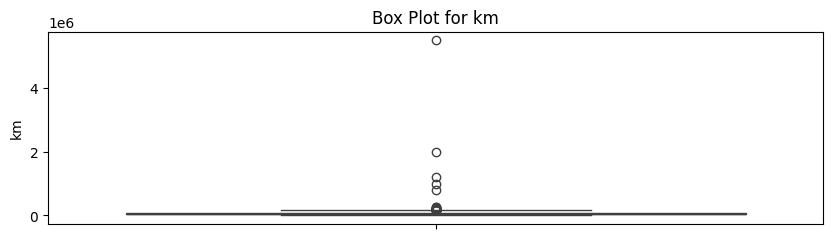

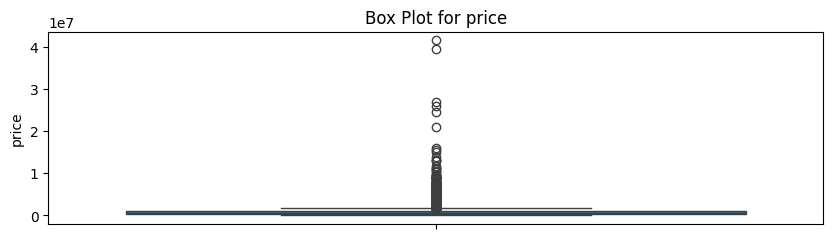

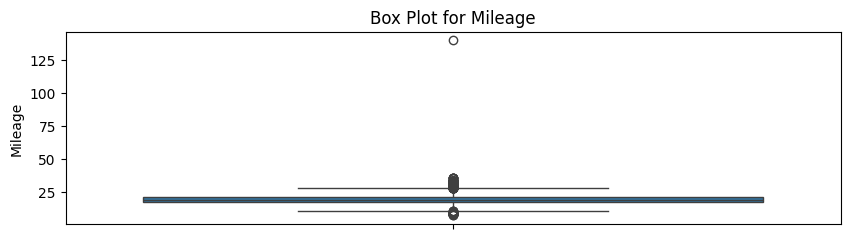

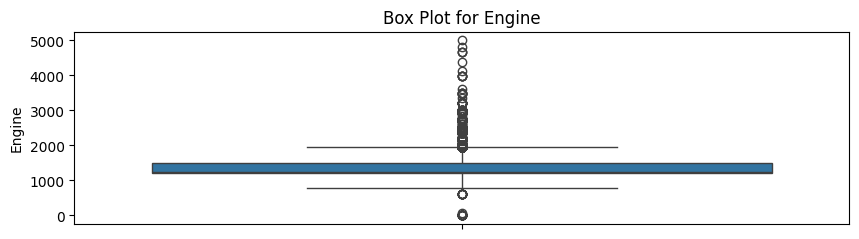

In [4]:
def boxplot_vis(df, col):
    for column in col:
        if column in df.columns:
            plt.figure(figsize=(10, 2.5))
            sns.boxplot(data=df[column])
            plt.title(f'Box Plot for {column}')
            plt.show()
        else:
            print(f"Column '{column}' does not exist in the DataFrame.")

boxplot_vis(df2,['km','price', 'Mileage','Engine'])

In [5]:
def outlier_capping(df, column, new_col):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (1.5*iqr)
    lower_threshold = df[column].quantile(0.25) - (1.5*iqr)
    df[new_col] = df[column].clip(lower_threshold, upper_threshold)

outlier_capping(df2, 'km', 'km')
outlier_capping(df2, 'price', 'price')
outlier_capping(df2, 'Mileage', 'Mileage')
outlier_capping(df2, 'Engine', 'Engine')

C:\Users\User\AppData\Local\Temp\ipykernel_7560\2434792620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[column].clip(lower_threshold, upper_threshold)
C:\Users\User\AppData\Local\Temp\ipykernel_7560\2434792620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[column].clip(lower_threshold, upper_threshold)
C:\Users\User\AppData\Local\Temp\ipykernel_7560\2434792620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

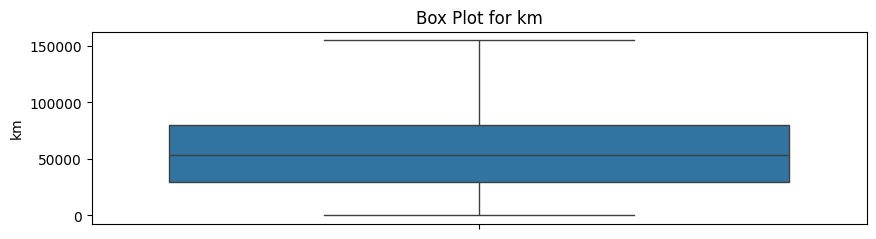

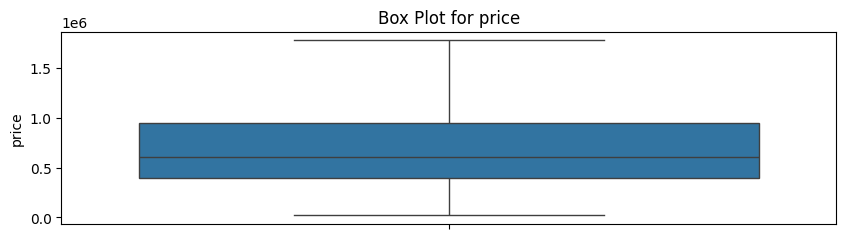

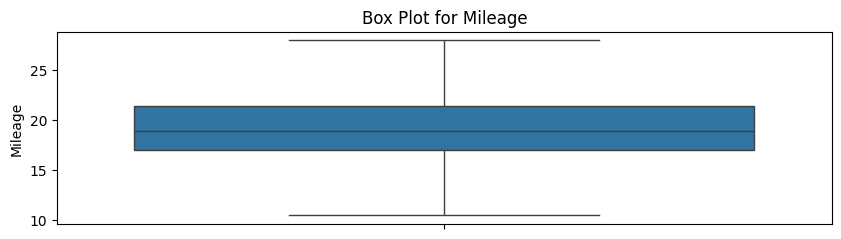

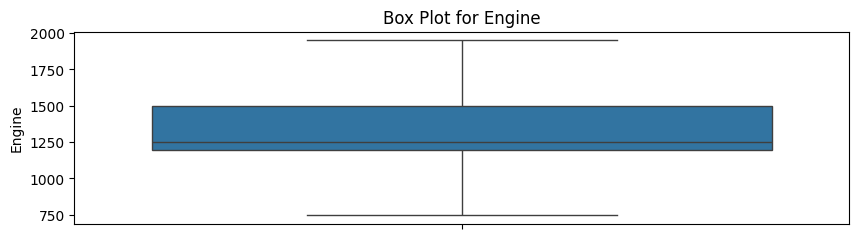

In [6]:
boxplot_vis(df2,['km','price', 'Mileage','Engine'])

In [7]:
one_hot_columns = ['bt', 'transmission', 'ft', 'City']
label_column = 'oem'

X = df2.drop('price', axis=1)
Y = df2['price']

# 1. One-Hot Encoding for selected columns
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first') # drop='first' to prevent multicollinearity
X_one_hot_encoded = one_hot_encoder.fit_transform(X[one_hot_columns])

# Convert one-hot encoded columns into a DataFrame
one_hot_encoded_columns = one_hot_encoder.get_feature_names_out(one_hot_columns)
X_one_hot_encoded_df = pd.DataFrame(X_one_hot_encoded, columns=one_hot_encoded_columns)

# 2. Label Encoding for 'oem'
label_encoder = LabelEncoder()
X['oem_encoded'] = label_encoder.fit_transform(X[label_column])

# Combine one-hot encoded columns with numeric features and the label encoded 'oem' column
X_numeric = X.drop(one_hot_columns + [label_column], axis=1)  # Drop original categorical columns
X_final = pd.concat([X_numeric.reset_index(drop=True), X_one_hot_encoded_df.reset_index(drop=True)], axis=1)


scaler = StandardScaler()

numeric_columns = ['km', 'Year of Manufacture', 'Engine']
X_final[['km', 'Year of Manufacture', 'Engine']] = scaler.fit_transform(X_final[numeric_columns])

with open('test2_scale_encoder_.pkl', 'wb') as file:
    pickle.dump((one_hot_encoder, label_encoder, scaler), file)

In [8]:
X_final.head()

,km,ownerNo,Seats,Year of Manufacture,Mileage,Engine,oem_encoded,bt_Coupe,bt_Hatchback,bt_Hybrids,...,transmission_Manual,ft_Diesel,ft_Electric,ft_Lpg,ft_Petrol,City_chennai,City_delhi,City_hyderabad,City_jaipur,City_kolkata
0,-0.735508,2,5,0.371500,17.00,0.377097,6,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.352197,1,5,0.371500,23.84,-0.512863,29,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.178542,1,5,-0.700262,19.10,-0.518835,9,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.075393,1,5,-0.432322,23.65,-0.366527,20,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.113002,1,5,0.907382,17.10,1.728462,12,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X = X_final.copy()
Y = df2['price']

In [10]:
X = X_final.copy()
Y = df2['price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

# Initialize and train the model
model = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)
model.fit(X_train, Y_train)

# Make predictions
pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_true= Y_test, y_pred= pred)
rmse = np.sqrt(mean_squared_error(y_true= Y_test, y_pred= pred))
evs = explained_variance_score(y_true= Y_test, y_pred= pred)
r_square_score = r2_score(y_true= Y_test, y_pred= pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Explained Variance Score: {evs}')
print(f'R-squared: {r_square_score}')


Mean Squared Error: 17844197505.48263
Root Mean Squared Error: 133582.17510387616
Explained Variance Score: 0.9228166678811021
R-squared: 0.9226985061742146


In [11]:
from sklearn.model_selection import KFold, cross_val_score

# Assuming X and Y are already defined and preprocessed
X = X_final.copy()
Y = df2['price']

# Initialize the RandomForestRegressor
model = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# Define the number of splits (k value, typically 5 or 10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Perform cross-validation and calculate the scores (using RMSE)
cv_scores = cross_val_score(model, X, Y, cv=kf, scoring='neg_mean_squared_error')

# Since cross_val_score gives negative MSE (by convention), we take the negative and then square root for RMSE
rmse_scores = np.sqrt(-cv_scores)

# Print results
print(f'Cross-Validation RMSE Scores: {rmse_scores}')
print(f'Mean RMSE: {rmse_scores.mean()}')
print(f'Standard Deviation of RMSE: {rmse_scores.std()}')


Cross-Validation RMSE Scores: [134404.85596151 122594.33285469 120205.32205641 134823.28354641
 127566.4091313 ]
Mean RMSE: 127918.8407100633
Standard Deviation of RMSE: 5961.7562288694635


In [12]:
import pickle

# After training the model
model = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)
model.fit(X_train, Y_train)

# Save the trained model to a pickle file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully as 'random_forest_model.pkl'")


Model saved successfully as 'random_forest_model.pkl'


TESTING TRAINED MODEL

In [23]:

# 1. Load the saved encoders, scaler, and model from pickle
with open('test2_scale_encoder_.pkl', 'rb') as file:
    one_hot_encoder, label_encoder, scaler = pickle.load(file)

with open('random_forest_model.pkl', 'rb') as file:
    model = pickle.load(file)

# 2. Define the new data point
new_data = pd.DataFrame([{
    'bt': 'SUV',
    'transmission': 'Manual',
    'oem': 'Maruti',
    'ft': 'Diesel',
    'km': 60000,
    'ownerNo': 1,
    'Seats': 5,
    'Year of Manufacture': 2015,
    'Mileage': 23.65,
    'Engine': 1248.0,
    'City': 'bangalore'
}])

# 3. Apply one-hot encoding for categorical columns
one_hot_columns = ['bt', 'transmission', 'ft', 'City']
new_data_one_hot_encoded = one_hot_encoder.transform(new_data[one_hot_columns])
one_hot_encoded_columns = one_hot_encoder.get_feature_names_out(one_hot_columns)
new_data_one_hot_encoded_df = pd.DataFrame(new_data_one_hot_encoded, columns=one_hot_encoded_columns)

# 4. Apply label encoding for 'oem' column
new_data['oem_encoded'] = label_encoder.transform(new_data['oem'])

# 5. Drop the original categorical columns
new_data_numeric = new_data.drop(one_hot_columns + ['oem'], axis=1)

# 6. Combine one-hot encoded columns and numeric columns
new_data_final = pd.concat([new_data_numeric.reset_index(drop=True), new_data_one_hot_encoded_df.reset_index(drop=True)], axis=1)

# 7. Scale the numeric features (km, Year of Manufacture, Engine)
numeric_columns = ['km', 'Year of Manufacture', 'Engine']
new_data_final[numeric_columns] = scaler.transform(new_data_final[numeric_columns])

# 8. Predict using the trained model
predicted_price = model.predict(new_data_final)

# 9. Output the predicted price
print(f'Predicted price for the new data: {predicted_price[0]}')


Predicted price for the new data: 717715.1130952381


In [27]:
df2['Mileage'].max()

np.float64(27.954999999999995)

In [29]:
df2['Engine'].max()
df2['Engine'].min()

np.float64(745.5)